# Финальный проект: идентификация интернет-пользователей.

Данный проект посвящен задаче идентификации пользователя по его поведению в сети Интернет. Это сложная и интересная задача на стыке анализа данных и поведенческой психологии. В качестве примера, компания Яндекс решает задачу идентификации взломщика почтового ящика по его поведению. Если выразить идею данной задачи в краткой форме, то она состоит в том, что взломщик будет себя вести не так, как владелец ящика: он может не удалять сообщения сразу по прочтении, как это делал хозяин, он будет по-другому ставить флажки сообщениям и даже по-своему двигать мышкой. Тогда такого злоумышленника можно идентифицировать и "выкинуть" из почтового ящика, предложив хозяину войти по SMS-коду.

В данном проекте будет решаться похожая задача: необходимо проанализировать последовательность из нескольких веб-сайтов, посещенных подряд одним и тем же человеком, и определить, Элис это (истинный пользователь) или взломщик (кто-то другой). Этой задаче посвящено соревнование на Kaggle, откуда и будут взяты исходные данные, и где будет проводиться итоговая оценка качества построенной модели.(ссылка на соревнование - https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2)

#### Цель проекта

Построение модели, способной определить по последовательности из нескольких веб-сайтов, посещенных подряд одним и тем же человеком, является ли пользователь истинным или ложным (взломщиком)

#### Задачи проекта:

1) Описать исходные данные;

2) Произвести первичный анализ признаков;

3) Произвести визуальный анализ признаков;

4) Создать дополнительные признаки;

5) Обучить модель и подобрать параметры;

6) Построить кривую валидации;

7) Написать вывод.

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, hstack
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV

## 1. Описание исходных данных.

Для решения данной задачи предоставляются следующие данные:

обучающая выборка, которая приведена в файле train_sessions.csv;

тестовая выборка, в которой отсутствует целевой признак target и находящаяся в файле test_sessions.csv;

словарь, находящийся в файле site_dic.pkl и в котором приведены названия сайтов с соответствующими им индексами.

Обучающая выборка состоит из объектов, которые мы будем называть сессиями. Сессия - последовательность из веб-сайтов, посещенных подряд одним и тем же пользователем. Сессии пользователей выделены таким образом, что они не могут быть длинее получаса или 10 сайтов. То есть сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд, либо когда сессия заняла по времени более 30 минут. Каждая сессия обладает следующими признаками:

Признаки site_i – это индексы посещенных сайтов (расшифровка дана в pickle-файле со словарем site_dic.pkl);

Признаки time_j – время посещения сайтов site_j;

Целевой признак target – факт того, что сессия принадлежит Элис (то есть что именно Элис ходила по всем этим сайтам).

## 2. Первичный анализ признаков.

Посмотрим на обучающую и тестовую выборки.

In [2]:
PATH_TO_DATA = u'D:\capstone_user_identification'

In [3]:
time_columns = ['time{}'.format(i) for i in range(1, 11)]

train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id', 
                       parse_dates=time_columns)
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id', 
                      parse_dates=time_columns)

In [4]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [5]:
test_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,2014-05-16 15:05:40,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


Отсортируем обучающую выборку по времени.

In [6]:
train_df_sorted = train_df.sort_values('time1')

Объединим обучающую и тестовую выборки – это понадобится, чтобы потом вместе привести их к разреженному формату.

In [7]:
train_test_df = pd.concat([train_df, test_df])

C:\Users\vaper\Anaconda2.2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


Посмотрим на статистику признаков.

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
site1     253561 non-null int64
time1     253561 non-null datetime64[ns]
site2     250098 non-null float64
time2     250098 non-null datetime64[ns]
site3     246919 non-null float64
time3     246919 non-null datetime64[ns]
site4     244321 non-null float64
time4     244321 non-null datetime64[ns]
site5     241829 non-null float64
time5     241829 non-null datetime64[ns]
site6     239495 non-null float64
time6     239495 non-null datetime64[ns]
site7     237297 non-null float64
time7     237297 non-null datetime64[ns]
site8     235224 non-null float64
time8     235224 non-null datetime64[ns]
site9     233084 non-null float64
time9     233084 non-null datetime64[ns]
site10    231052 non-null float64
time10    231052 non-null datetime64[ns]
target    253561 non-null int64
dtypes: datetime64[ns](10), float64(9), int64(2)
memory usage: 42.6 MB


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82797 entries, 1 to 82797
Data columns (total 20 columns):
site1     82797 non-null int64
time1     82797 non-null datetime64[ns]
site2     81308 non-null float64
time2     81308 non-null datetime64[ns]
site3     80075 non-null float64
time3     80075 non-null datetime64[ns]
site4     79182 non-null float64
time4     79182 non-null datetime64[ns]
site5     78341 non-null float64
time5     78341 non-null datetime64[ns]
site6     77566 non-null float64
time6     77566 non-null datetime64[ns]
site7     76840 non-null float64
time7     76840 non-null datetime64[ns]
site8     76151 non-null float64
time8     76151 non-null datetime64[ns]
site9     75484 non-null float64
time9     75484 non-null datetime64[ns]
site10    74806 non-null float64
time10    74806 non-null datetime64[ns]
dtypes: datetime64[ns](10), float64(9), int64(1)
memory usage: 13.3 MB


Пропуски возникают там, где сессии короткие (менее 10 сайтов). Скажем, если человек 1 января 2021 года посетил vk.com в 20:01, потом yandex.ru в 20:29, затем google.com в 20:33, то первая его сессия будет состоять только из двух сайтов (site1 – ID сайта vk.com, time1 – 2021-01-01 20:01:00, site2 – ID сайта yandex.ru, time2 – 2021-01-01 20:29:00, остальные признаки – NaN), а начиная с google.com пойдет новая сессия, потому что уже прошло более 30 минут с момента посещения vk.com.

В обучающей выборке – 2297 сессий одного пользователя (Alice) и 251264 сессий – других пользователей, не Элис.

Дисбаланс классов очень сильный, поэтому смотреть на долю верных ответов непоказательно. Также можно попробовать воспользоваться подходом балансировки данных - oversampling.

In [10]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

Посмотрим на словарь с индексами сайтов.

In [11]:
with open(os.path.join(PATH_TO_DATA, 'site_dic.pkl'), 'rb') as f:
    site_dic = pickle.load(f)

list(site_dic.items())[:10]

[(u'i1-js-14-3-01-11544-644949368-i.init.cedexis-radar.net', 13852),
 (u'static.vol24.fr', 6240),
 (u'mars.nasa.gov', 39840),
 (u'scholar.google.fr', 3899),
 (u'9zouxfza1h.s.ad6media.fr', 9677),
 (u'afecaa4b0c028e55502bc297410239d4d.profile.mad50.cloudfront.net', 34973),
 (u'www.decoration-stickers.com', 46579),
 (u'www.aldaniti.net', 252),
 (u'cc.bingj.com', 36904),
 (u'www.bwin.fr', 6824)]

Пока для прогноза будем использовать только индексы посещенных сайтов. Индексы нумеровались с 1, так что заменим пропуски на нули.

In [12]:
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')

In [13]:
train_test_df_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
1,718,0,0,0,0,0,0,0,0,0
2,890,941,3847,941,942,3846,3847,3846,1516,1518
3,14769,39,14768,14769,37,39,14768,14768,14768,14768
4,782,782,782,782,782,782,782,782,782,782
5,22,177,175,178,177,178,175,177,177,178


##### Создадим разреженные матрицы X_sparse_train и X_sparse_test.

Для этого сначала переведем объединенную матрицу train_test_df_sites в разряженный формат, а потом разделим её обратно на обучающую и тестовую части. Так как в исходных данных у нас были пропуски и мы заменили их нулями, то в полученной разряженной матрице первый признак (сколько раз попался 0) по смыслу будет отличен от остальных (сколько раз попался сайт с индексом i). Поэтому первый столбец разряженной матрицы будет удален.

In [14]:
def transform_to_csr_matrix(X):
    """Converts the matrix to a sparse format"""
    
    indptr = [0]
    indices = []
    data = []
    vocabulary = {}
    for session in X.values:
        for site in session:
            index = vocabulary.setdefault(site, site)
            indices.append(index)
            data.append(1)
        indptr.append(len(indices))
        
    return csr_matrix((data, indices, indptr))[:, 1:]

In [15]:
train_test_sparse = transform_to_csr_matrix(train_test_df_sites)
X_train_sparse = train_test_sparse[:train_df.shape[0], :]
X_test_sparse = train_test_sparse[train_df.shape[0]:, :]
# Выделим в отдельный вектор y ответы на обучающей выборке.
y = train_df.target.values

In [16]:
print('X_train_sparse shape: {} X_test_sparse shape: {}'.format(X_train_sparse.shape, 
                                                                X_test_sparse.shape))

X_train_sparse shape: (253561, 48371) X_test_sparse shape: (82797, 48371)


Разобьем обучающую выборку на 2 части в пропорции 7/3.

In [17]:
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]

## 3. Построение бейзлайна.

Создадим объект sklearn.linear_model.SGDClassifier с логистической функцией потерь и параметром random_state=17 для воспроизводимости.

In [18]:
sgd_logit = SGDClassifier(loss='log', random_state=17, n_jobs=-1)
sgd_logit.fit(X_train, y_train)

C:\Users\vaper\Anaconda2.2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=17, shuffle=True,
       tol=None, verbose=0, warm_start=False)

Сделаем прогноз в виде предсказанных вероятностей того, что это сессия Элис, на отложенной выборке (X_valid, y_valid).

In [19]:
logit_valid_pred_proba = sgd_logit.predict_proba(X_valid)[:, 1]

Посчитаем ROC AUC логистической регрессии, обученной с помощью стохастического градиентного спуска, на отложенной выборке.

In [20]:
valid_roc_auc = round(roc_auc_score(y_valid, logit_valid_pred_proba), 3)
print('Baseline valid ROC AUC score: {}'.format(valid_roc_auc))

Baseline valid ROC AUC score: 0.934


## 4. Создание новых признаков.

Так как в исходных данных у нас имеются признаки о индексе сайта и времени его посещения, то на основе их сконструируем 13 новых признаков:

1) session_timespan – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах);

2) #unique_sites – число уникальных сайтов в сессии;

3) start_hour – час начала сессии (то есть час в записи минимального timestamp среди десяти);

4) day_of_week – день недели (то есть день недели в записи минимального timestamp среди десяти);

5) а также признаки time_diff1 - time_diff9, показывающие время в секундах, проведенное за определенным сайтом в сессии.

In [21]:
def feature_engineering(X, train=True):
    '''
    
    Creating new features:
    - session_timespan;
    - #unique_sites;
    - start_hour;
    - day_of_week;
    - time_diff1 - time_diff9. 
    
    '''
    sites = X[['site{}'.format(i) for i in range(1, 11)]].fillna(0).astype('int').values
    times = X[['time{}'.format(i) for i in range(1, 11)]]
    new_features = pd.DataFrame()
    
    for i in range(1, 10):
        new_features['time_diff{}'.format(i)] = ( 
            (pd.to_datetime(times['time{}'.format(i + 1)]) \
            - pd.to_datetime(times['time{}'.format(i)]))).dt.total_seconds().fillna(0)
        
    new_features['session_timespan'] = np.sum(new_features, axis=1)
    new_features['#unique_sites'] = [len(np.unique(session[session != 0])) 
                                     for session in sites]
    new_features['start_hour'] = pd.to_datetime(times['time1']).dt.hour
    new_features['day_of_week'] = pd.to_datetime(times['time1']).dt.weekday
    if train:
        new_features['target'] = X.target
    
    return new_features

Создадим новые признаки для обучающей и тестовой выборок.

In [22]:
new_train_features = feature_engineering(train_df)
new_test_features = feature_engineering(test_df, train=False)

## 5. Визуальный анализ признаков.

Отделим сессии Элис от сессий других пользователей и создадим списки значений параметров, с помощью которых будем строить графики.

In [23]:
targets_data = [new_train_features[new_train_features['target']==i] for i in (0, 1)]

colors = ['red', 'blue']
labels = ['Other', 'Alice']

Посмотрим на распределение признака #unique_sites.

Распределение признака #unique_sites:


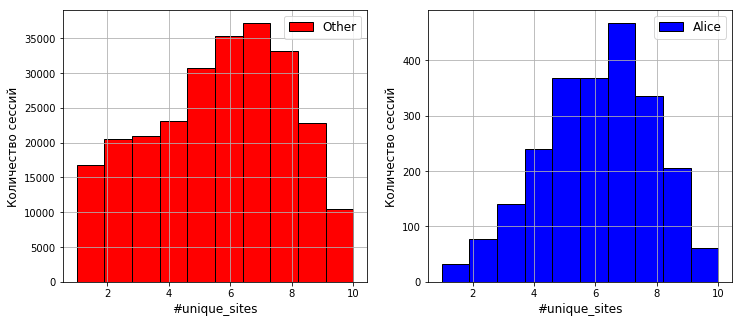

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for i, target in enumerate(targets_data):
    axs[i].hist(target['#unique_sites'], bins=10, 
                color=colors[i], edgecolor='black', 
                label=labels[i])
    axs[i].grid(True)
    axs[i].legend(fontsize='large')
    axs[i].set_xlabel(u'#unique_sites', fontsize='large')
    axs[i].set_ylabel(u'Количество сессий', fontsize='large')
    
print('Распределение признака #unique_sites:')

Посмотрим на распределение признака start_hour.

Распределение признака start_hour:


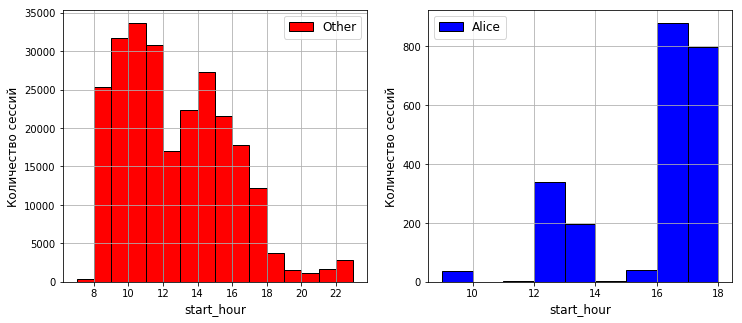

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for i, target in enumerate(targets_data):
    axs[i].hist(target['start_hour'], 
                bins=target['start_hour'].max() - \
                target['start_hour'].min(), 
                color=colors[i], edgecolor='black', 
                label=labels[i])
    axs[i].grid(True)
    axs[i].legend(fontsize='large')
    axs[i].set_xlabel(u'start_hour', fontsize='large')
    axs[i].set_ylabel(u'Количество сессий', fontsize='large')
    
print('Распределение признака start_hour:')

Посмотрим на распределение признака day_of_week.

Распределение признака day_of_week:


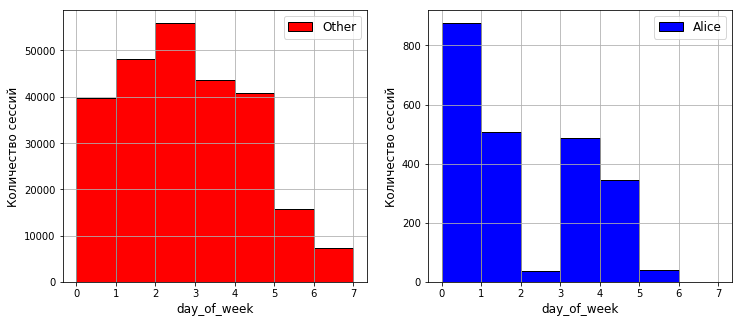

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for i, target in enumerate(targets_data):
    axs[i].hist(target['day_of_week'], 
                bins=7, range=(0, 7), color=colors[i], 
                edgecolor='black', label=labels[i])
    axs[i].grid(True)
    axs[i].legend(fontsize='large')
    axs[i].set_xlabel('day_of_week', fontsize='large')
    axs[i].set_ylabel(u'Количество сессий', fontsize='large')
    
print('Распределение признака day_of_week:')

Из этих графиков можно сделать следующие выводы:

1) Элис почти не отличается от остальных пользователей по количеству уникальных сайтов в сессии;

2) Элис выходит в Интернет в основном только вечером;

3) Элис пользуется интернетом в основном только в будние дни.

## 6. Создание дополнительных признаков.

На основе этих выводов добавим еще 2 дополнительных признака:

1) weekend - является ли день выходным (False, True);

2) time_of_day - время суток (0 - с 00:00 до 06:00, 1 - с 06:00 до 12:00, 2 - с 12:00 до 18:00, 3 - с 18:00 до 00:00)

In [27]:
def feature_engineering2(X):
    '''
    
    Creating new features:
    - weekend;
    - time_of_day.
    
    '''
    
    time1 = X['time1']
    new_features = pd.DataFrame() 
    
    # Введем вспомогательную функцию для вычисления признака time_of_day.
    def time_of_day(hour):
        if 0 <= hour < 6:
            return 0
        elif 6 <= hour < 12:
            return 1
        elif 12 <= hour < 18:
            return 2
        elif 18 <= hour:
            return 3
    
    new_features['weekend'] = time1.dt.weekday.isin((5, 6))
    new_features['time_of_day'] = time1.dt.hour.apply(time_of_day)
    
    return new_features

Вычислим дополнительные признаки для обучающей и вспомогательной выборок.

In [28]:
new_train_features2 = feature_engineering2(train_df)
new_test_features2 = feature_engineering2(test_df)

## 7. Масштабирование вещественных признаков.

Соединим все созданные признаки.

In [29]:
all_new_train_features = pd.concat([new_train_features.iloc[:, :-1], 
                                    new_train_features2], axis=1)
all_new_test_features = pd.concat([new_test_features, 
                                   new_test_features2], axis=1)

Отделим вещественные признаки от категориальных.

In [30]:
new_num_train_features = all_new_train_features.loc[:, :'#unique_sites']
new_num_test_features = all_new_test_features.loc[:, :'#unique_sites']

Произведем масштабирование вещественных признаков.

In [31]:
scaler = StandardScaler()
scaled_num_train_features = scaler.fit_transform(new_num_train_features)
scaled_num_test_features = scaler.fit_transform(new_num_test_features)

Создадим DataFram'ы из полученных признаков.

In [32]:
scaled_num_train_features_df = pd.DataFrame(scaled_num_train_features, 
                                            columns=['time_diff{}'.format(i) 
                                                     for i in range(1, 10)] + \
                                                    ['session_timespan', 
                                                     '#unique_sites'])
scaled_num_test_features_df = pd.DataFrame(scaled_num_test_features, 
                                           columns=['time_diff{}'.format(i) 
                                                    for i in range(1, 10)] + \
                                                   ['session_timespan', 
                                                    '#unique_sites'])

## 8. Кодирование категориальных признаков.

Отделим категориальные признаки от вещественных.

In [33]:
new_cat_train_features = all_new_train_features[['start_hour', 
                                                 'day_of_week', 
                                                 'time_of_day']]
new_cat_test_features = all_new_test_features[['start_hour', 
                                               'day_of_week', 
                                               'time_of_day']]

Кодирование категориальных признаков.

In [34]:
encoder = OneHotEncoder()
new_cat_train_ohe = encoder.fit_transform(new_cat_train_features)
new_cat_test_ohe = encoder.transform(new_cat_test_features)

Создадим DataFram'ы из полученных признаков.

In [54]:
columns_start_hour = ['start_hour_{}'.format(i)  for i in range(7, 24)]
columns_day_of_week = ['day_of_week_{}'.format(i) for i in range(0, 7)]
columns_time_of_day = ['time_of_day_{}'.format(i) for i in range(0, 3)]

new_train_cat_ohe_df = pd.DataFrame(new_cat_train_ohe.toarray(), 
                                    columns=columns_start_hour + columns_day_of_week + columns_time_of_day, 
                                    index=range(0, new_cat_train_ohe.toarray().shape[0]))
new_test_cat_ohe_df = pd.DataFrame(new_cat_test_ohe.toarray(), 
                                    columns=columns_start_hour + columns_day_of_week + columns_time_of_day, 
                                   index=range(0, new_cat_test_ohe.toarray().shape[0]))

## 9. Объединение исходных данных с созданными признаками и разделение полученного результата на обучающую и тестовую части.

Объединим отмасштабированные вещественные признаки и закодированные категориальные.

In [55]:
new_train_features3 = pd.concat([scaled_num_train_features_df, 
                                 new_train_cat_ohe_df], axis=1)
new_test_features3 = pd.concat([scaled_num_test_features_df, 
                                 new_test_cat_ohe_df], axis=1)

Приведем полученные матрицы признаков к разреженному формату.

In [56]:
new_train_features3_sparse = csr_matrix(new_train_features3)
new_test_features3_sparse = csr_matrix(new_test_features3)

Теперь объединим эти матрицы с исходными данными.

In [57]:
X_train_new_features = hstack((X_train_sparse, 
                               new_train_features3_sparse))
X_test_nf3= hstack((X_test_sparse, new_test_features3_sparse))

Разделим полученный результат на обучение и валидацию.

In [58]:
X_train_nf3, X_valid_nf3, y_train, y_valid = train_test_split(X_train_new_features, 
                                                              y, test_size=0.25, 
                                                              shuffle=True, random_state=42)

## 10. Обучение модели и подбор параметров.

Зададим тип кросс-валидации.

In [59]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

Посмотрим на качество модели без подбора параметров.

In [60]:
sgd_logit2 = SGDClassifier(loss='log', random_state=17, n_jobs=-1)

new_features3_cvs = cross_val_score(sgd_logit2, X_train_nf3, 
                                    y_train, cv=skf, 
                                    scoring='roc_auc')
print('SGDClassifier with new features cross_val_score:')
print('{}, {}\n'.format(new_features3_cvs, new_features3_cvs.mean()))

sgd_logit2.fit(X_train_nf3, y_train)
roc_auc_nf3 = roc_auc_score(y_valid, 
                            sgd_logit2.predict_proba(X_valid_nf3)[:, 1])
print('SGDClassifier with new features valid ROC AUC score: {}'.format(roc_auc_nf3))

SGDClassifier with new features cross_val_score:
[0.97533245 0.97410106 0.97201602], 0.973816513136

SGDClassifier with new features valid ROC AUC score: 0.979352218217


Подберем параметры для SGDClassifier.

In [61]:
sgd_logit3 = SGDClassifier(loss='log', random_state=17, n_jobs=-1)

sgd_params = {'alpha': np.linspace(1e-5, 1e-1, 40), 
              'class_weight': [None, 'balanced']}
sgd_grid_searcher = GridSearchCV(sgd_logit3, sgd_params, 
                                 scoring='roc_auc', cv=skf,
                                 return_train_score=True,
                                 n_jobs=-1)
sgd_grid_searcher.fit(X_train_nf3, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
       error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=17, shuffle=True,
       tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': array([1.00000e-05, 2.57385e-03, 5.13769e-03, 7.70154e-03, 1.02654e-02,
       1.28292e-02, 1.53931e-02, 1.79569e-02, 2.05208e-02, 2.30846e-02,
       2.56485e-02, 2.82123e-02, 3.07762e-02, 3.33400e-02, 3.59038e-02,
       3.84677e-02, 4.10315e-02, 4.35954e-02, 4.61592e-02, 4.87...97446e-02, 9.23085e-02, 9.48723e-02, 9.74362e-02, 1.00000e-01]), 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbo

Посмотрим на лучшие результаты.

In [62]:
print('The best ROC AUC score: {}'.format(sgd_grid_searcher.best_score_))
print('The best params: {}'.format(sgd_grid_searcher.best_params_))

The best ROC AUC score: 0.976198871285
The best params: {'alpha': 0.002573846153846154, 'class_weight': 'balanced'}


Оценим качество SGDClassifier с подобранными параметрами на валидации.

In [63]:
sgd_roc_auc_best_params = roc_auc_score(y_valid, 
                                        sgd_grid_searcher.best_estimator_.predict_proba(X_valid_nf3)[:, 1])
print('SGDClassifier with the best params ROC AUC score: {}'.format(sgd_roc_auc_best_params))

SGDClassifier with the best params ROC AUC score: 0.979587697238


Теперь обучим LogisticRegression.

Посмотрим на качество модели без подбора параметров.

In [64]:
log_reg = LogisticRegression(solver='liblinear', random_state=17)

new_features3_cvs2 = cross_val_score(log_reg, X_train_nf3, 
                                     y_train, cv=skf, 
                                     scoring='roc_auc')
print('LogisticRegression with new features cross_val_score:')
print('{}, {}\n'.format(new_features3_cvs2, new_features3_cvs2.mean()))

log_reg.fit(X_train_nf3, y_train)
roc_auc_nf3_2 = roc_auc_score(y_valid, 
                              log_reg.predict_proba(X_valid_nf3)[:, 1])
print('LogisticRegression with new features valid ROC AUC score: {}'.format(roc_auc_nf3_2))

LogisticRegression with new features cross_val_score:
[0.98399552 0.98538809 0.9840928 ], 0.984492137522

LogisticRegression with new features valid ROC AUC score: 0.989704599403


Подберем параметры для LogisticRegression.

In [65]:
log_reg2 = LogisticRegression(solver='liblinear', random_state=42)
logit_params = {'C': np.linspace(0.1, 2, 50)}

logit_grid_searcher = GridSearchCV(log_reg2, logit_params, 
                                   scoring='roc_auc', cv=skf, 
                                   return_train_score=True, 
                                   n_jobs=-1)
logit_grid_searcher.fit(X_train_nf3, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([0.1    , 0.13878, 0.17755, 0.21633, 0.2551 , 0.29388, 0.33265,
       0.37143, 0.4102 , 0.44898, 0.48776, 0.52653, 0.56531, 0.60408,
       0.64286, 0.68163, 0.72041, 0.75918, 0.79796, 0.83673, 0.87551,
       0.91429, 0.95306, 0.99184, 1.03061, 1.06939, 1.10816, 1.14694,
   ...02, 1.6898 ,
       1.72857, 1.76735, 1.80612, 1.8449 , 1.88367, 1.92245, 1.96122,
       2.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

Посмотрим на лучшие результаты.

In [66]:
print('The best ROC AUC score: {}'.format(logit_grid_searcher.best_score_))
print('The best С value: {}'.format(logit_grid_searcher.best_params_))

The best ROC AUC score: 0.985170862008
The best С value: {'C': 2.0}


Оценим качество LogisticRegression с подобранными параметрами на валидации.

In [67]:
log_reg3 = LogisticRegression(C=logit_grid_searcher.best_params_['C'], 
                              solver='liblinear', random_state=17)

log_reg3.fit(X_train_nf3, y_train)

logit_roc_auc_best_c = roc_auc_score(y_valid, 
                                     log_reg3.predict_proba(X_valid_nf3)[:, 1])
print('LogisticRegression with best params ROC AUC score: {}'.format(logit_roc_auc_best_c))

LogisticRegression with best params ROC AUC score: 0.990096573625


Построим кривую валидации.

In [68]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

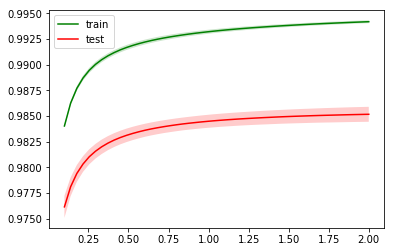

In [69]:
plot_validation_curves(logit_params['C'], logit_grid_searcher.cv_results_)

Построим кривую обучения.

In [70]:
def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

In [71]:
train_sizes = np.linspace(0.25, 1, 20)
n_train, val_train, val_test = learning_curve(log_reg3, X_train_nf3, 
                                              y_train, train_sizes=train_sizes, 
                                              cv=skf)

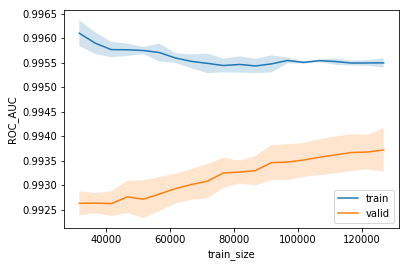

In [72]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='ROC_AUC')

## 11. Построение предсказаний на тестовых данных.

Создадим вспомогательную функцию для записи предсказаний в csv-файл.

In [73]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

Построим предсказания.

In [74]:
log_reg_test_pred_proba = log_reg3.predict_proba(X_test_nf3)[:, 1]
write_to_submission_file(log_reg_test_pred_proba, 'log_reg_result.csv')

Качество модели на тестовых данных: 0.94362

## 12. Выводы

##### Оценка модели.

Построенная модель логистической регрессии показывает следующие значения метрики ROC AUC:

1) на отложенной выборке ROC AUC = 0.990096573625;

2) на тестовой выборке ROC AUC = 0.94362.

Значение метрики ROC AUC имеет вероятностный смысл того, что если были выбраны случайный положительный и случайный отрицательный объекты выборки, положительный объект получит оценку принадлежности выше, чем отрицательный объект. Следовательно, для идеального алгоритма ROC AUC = 1, а для худшего ROC AUC = 0.5.

Оба значения метрики ROC AUC, которые мы получили для построенной модели, близки к 1. Таким образом, можно сказать, что построенная модель показывает хорошее качество.

##### Вывод.

В данном проекте была построена модель, способная определить, был ли совершен взлом аккаунта веб-сервиса. Особенностью данной модели является то, что она способна определить злоумышленника, даже если он не совершил никакого вредоносного действия. Осуществляется это на основе идеи о том, что поведение взломщика на веб-сервисе будет отличаться от поведения истинного пользователя. Таким образом, данная модель может использоваться в сфере информационной безопасности для обеспечения ещё большей защиты личных данных пользователей.

Для улучшения качества построенной модели можно рассмотреть следующие предложения:

1) использовать entity recognition, то есть не считать google.com, http://www.google.com и www.google.com разными сайтами;

2) сконструировать дополнительные признаки, которые точнее описывают сессии;

3) использование других алгоритмов.